##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tensorflow Lattice와 형상 제약 조건


<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/lattice/tutorials/shape_constraints"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/lattice/tutorials/shape_constraints.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/lattice/tutorials/shape_constraints.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/lattice/tutorials/shape_constraints.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

## 개요

이 튜토리얼은 TensorFlow Lattice(TFL) 라이브러리에서 제공하는 제약 조건 및 regularizer에 대한 개요입니다. 여기서는 합성 데이터세트에 TFL canned estimator를 사용하지만, 해당 튜토리얼의 모든 내용은 TFL Keras 레이어로 구성된 모델로도 수행될 수 있습니다.

계속하기 전에 런타임에 필요한 모든 패키지가 아래 코드 셀에서 가져온 대로 설치되어 있는지 먼저 확인하세요.

## 설정

TF Lattice 패키지 설치하기

In [2]:
#@test {"skip": true}
!pip install tensorflow-lattice

  Using cached tensorflow_lattice-2.0.9-py2.py3-none-any.whl (235 kB)


  Using cached graphviz-0.17-py3-none-any.whl (18 kB)


  Using cached dm_sonnet-2.0.0-py3-none-any.whl (254 kB)


  Using cached dm_tree-0.1.6-cp37-cp37m-manylinux_2_24_x86_64.whl (93 kB)
  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)


필수 패키지 가져오기

In [3]:
import tensorflow as tf

from IPython.core.pylabtools import figsize
import itertools
import logging
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
import tensorflow_lattice as tfl
logging.disable(sys.maxsize)

이 가이드에서 사용되는 기본값

In [4]:
NUM_EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE=0.01

## 레스토랑 순위 지정을 위한 훈련 데이터세트

사용자가 레스토랑 검색 결과를 클릭할지 여부를 결정하는 단순화된 시나리오를 상상해봅니다. 이 작업은 주어진 입력 특성에 따른 클릭률(CTR)을 예측하는 것입니다.

- 평균 평점(`avg_rating`): [1,5] 범위의 값을 가진 숫자 특성입니다.
- 리뷰 수(`num_reviews`): 200개로 제한되는 값이 있는 숫자 특성으로, 트렌드를 측정하는 데 사용됩니다.
- 달러 등급(`dollar_rating`): { "D", "DD", "DDD", "DDDD"} 세트에 문자열 값이 있는 범주형 특성입니다.

실제 CTR이 공식으로 제공되는 합성 데이터세트를 만듭니다. $$ CTR = 1 / (1 + exp{\mbox {b(dollar_rating)}-\mbox {avg_rating} \times log(\mbox {num_reviews}) / 4}) $$ 여기서 $b(\cdot)$는 각 `dollar_rating`을 기준값으로 변환합니다. $$ \mbox{D}\to 3,\ \ mbox{DD}\to 2,\ \ mbox{DDD}\to 4,\ \mbox{DDDD}\to 4.5. $$

이 공식은 일반적인 사용자 패턴을 반영합니다. 예를 들어 다른 모든 사항이 수정된 경우 사용자는 별표 평점이 더 높은 식당을 선호하며 '$$'식당은 '$'보다 더 많은 클릭을 받고 '$$$' 및 '$$$'가 이어집니다. 

In [5]:
def click_through_rate(avg_ratings, num_reviews, dollar_ratings):
  dollar_rating_baseline = {"D": 3, "DD": 2, "DDD": 4, "DDDD": 4.5}
  return 1 / (1 + np.exp(
      np.array([dollar_rating_baseline[d] for d in dollar_ratings]) -
      avg_ratings * np.log1p(num_reviews) / 4))

이 CTR 함수의 등고선도를 살펴보겠습니다.

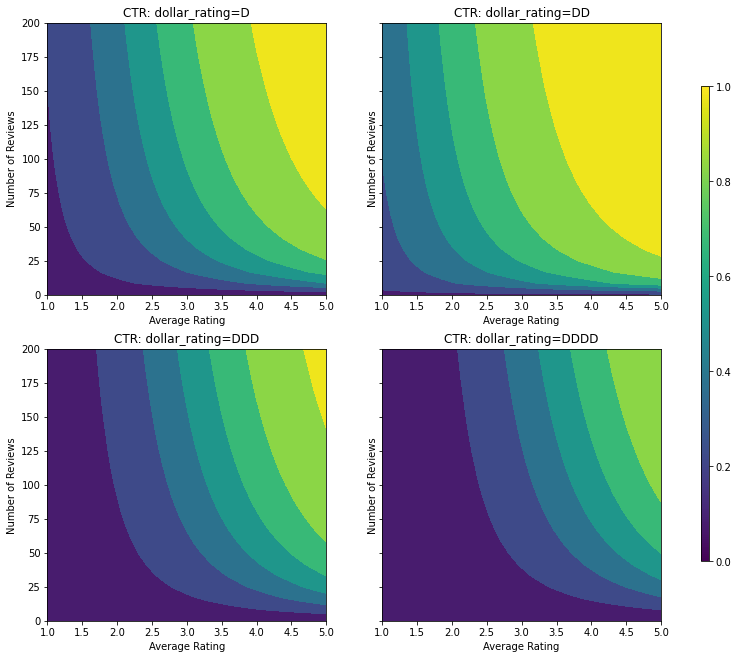

In [6]:
def color_bar():
  bar = matplotlib.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(0, 1, True),
      cmap="viridis",
  )
  bar.set_array([0, 1])
  return bar


def plot_fns(fns, split_by_dollar=False, res=25):
  """Generates contour plots for a list of (name, fn) functions."""
  num_reviews, avg_ratings = np.meshgrid(
      np.linspace(0, 200, num=res),
      np.linspace(1, 5, num=res),
  )
  if split_by_dollar:
    dollar_rating_splits = ["D", "DD", "DDD", "DDDD"]
  else:
    dollar_rating_splits = [None]
  if len(fns) == 1:
    fig, axes = plt.subplots(2, 2, sharey=True, tight_layout=False)
  else:
    fig, axes = plt.subplots(
        len(dollar_rating_splits), len(fns), sharey=True, tight_layout=False)
  axes = axes.flatten()
  axes_index = 0
  for dollar_rating_split in dollar_rating_splits:
    for title, fn in fns:
      if dollar_rating_split is not None:
        dollar_ratings = np.repeat(dollar_rating_split, res**2)
        values = fn(avg_ratings.flatten(), num_reviews.flatten(),
                    dollar_ratings)
        title = "{}: dollar_rating={}".format(title, dollar_rating_split)
      else:
        values = fn(avg_ratings.flatten(), num_reviews.flatten())
      subplot = axes[axes_index]
      axes_index += 1
      subplot.contourf(
          avg_ratings,
          num_reviews,
          np.reshape(values, (res, res)),
          vmin=0,
          vmax=1)
      subplot.title.set_text(title)
      subplot.set(xlabel="Average Rating")
      subplot.set(ylabel="Number of Reviews")
      subplot.set(xlim=(1, 5))

  _ = fig.colorbar(color_bar(), cax=fig.add_axes([0.95, 0.2, 0.01, 0.6]))


figsize(11, 11)
plot_fns([("CTR", click_through_rate)], split_by_dollar=True)

### 데이터 준비하기


이제 합성 데이터세트를 만들어야 합니다. 레스토랑과 해당 특징의 시뮬레이션된 데이터세트를 생성하는 것으로 작업을 시작합니다.

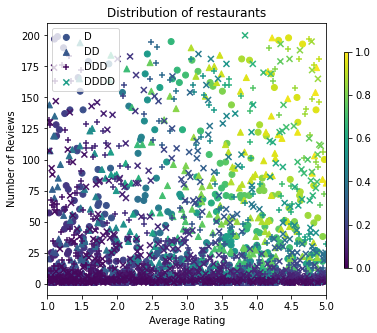

In [7]:
def sample_restaurants(n):
  avg_ratings = np.random.uniform(1.0, 5.0, n)
  num_reviews = np.round(np.exp(np.random.uniform(0.0, np.log(200), n)))
  dollar_ratings = np.random.choice(["D", "DD", "DDD", "DDDD"], n)
  ctr_labels = click_through_rate(avg_ratings, num_reviews, dollar_ratings)
  return avg_ratings, num_reviews, dollar_ratings, ctr_labels


np.random.seed(42)
avg_ratings, num_reviews, dollar_ratings, ctr_labels = sample_restaurants(2000)

figsize(5, 5)
fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=False)
for rating, marker in [("D", "o"), ("DD", "^"), ("DDD", "+"), ("DDDD", "x")]:
  plt.scatter(
      x=avg_ratings[np.where(dollar_ratings == rating)],
      y=num_reviews[np.where(dollar_ratings == rating)],
      c=ctr_labels[np.where(dollar_ratings == rating)],
      vmin=0,
      vmax=1,
      marker=marker,
      label=rating)
plt.xlabel("Average Rating")
plt.ylabel("Number of Reviews")
plt.legend()
plt.xlim((1, 5))
plt.title("Distribution of restaurants")
_ = fig.colorbar(color_bar(), cax=fig.add_axes([0.95, 0.2, 0.01, 0.6]))

훈련, 검증 및 테스트 데이터세트를 생성해 보겠습니다. 검색 결과에 레스토랑이 표시되면 사용자의 참여(클릭 또는 클릭 없음)를 샘플 포인트로 기록할 수 있습니다.

실제로 사용자가 모든 검색 결과를 확인하지 않는 경우가 많습니다. 즉, 사용자는 현재 사용 중인 순위 모델에서 이미 '좋은' 것으로 간주되는 식당만 볼 수 있습니다. 결과적으로 '좋은' 레스토랑은 훈련 데이터세트에서 더 자주 좋은 인상을 남기고 더 과장되게 표현됩니다. 더 많은 특성을 사용할 때 훈련 데이터세트에서는 특성 공간의 '나쁜' 부분에 큰 간격이 생길 수 있습니다.

모델이 순위 지정에 사용되면 훈련 데이터세트로 잘 표현되지 않는 보다 균일한 분포로 모든 관련 결과에 대해 평가되는 경우가 많습니다. 이 경우 과도하게 표현된 데이터 포인트에 과대 적합이 발생하여 일반화될 수 없기 때문에, 유연하고 복잡한 모델은 실패할 수 있습니다. 이 문제는 도메인 지식을 적용하여 모델이 훈련 데이터세트에서 선택할 수 없을 때 합리적인 예측을 할 수 있도록 안내하는 *형상 제약 조건*을 추가함으로써 처리합니다.

이 예에서 훈련 데이터세트는 대부분 우수하고 인기 있는 음식점과의 사용자 상호 작용으로 구성됩니다. 테스트 데이터세트에는 위에서 설명한 평가 설정을 시뮬레이션하도록 균일한 분포가 있습니다. 해당 테스트 데이터세트는 실제 문제 설정에서는 사용할 수 없습니다.

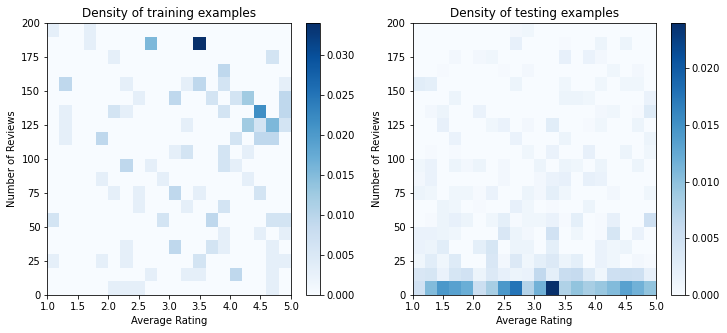

In [8]:
def sample_dataset(n, testing_set):
  (avg_ratings, num_reviews, dollar_ratings, ctr_labels) = sample_restaurants(n)
  if testing_set:
    # Testing has a more uniform distribution over all restaurants.
    num_views = np.random.poisson(lam=3, size=n)
  else:
    # Training/validation datasets have more views on popular restaurants.
    num_views = np.random.poisson(lam=ctr_labels * num_reviews / 50.0, size=n)

  return pd.DataFrame({
      "avg_rating": np.repeat(avg_ratings, num_views),
      "num_reviews": np.repeat(num_reviews, num_views),
      "dollar_rating": np.repeat(dollar_ratings, num_views),
      "clicked": np.random.binomial(n=1, p=np.repeat(ctr_labels, num_views))
  })


# Generate datasets.
np.random.seed(42)
data_train = sample_dataset(500, testing_set=False)
data_val = sample_dataset(500, testing_set=False)
data_test = sample_dataset(500, testing_set=True)

# Plotting dataset densities.
figsize(12, 5)
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=False)
for ax, data, title in [(axs[0], data_train, "training"),
                        (axs[1], data_test, "testing")]:
  _, _, _, density = ax.hist2d(
      x=data["avg_rating"],
      y=data["num_reviews"],
      bins=(np.linspace(1, 5, num=21), np.linspace(0, 200, num=21)),
      density=True,
      cmap="Blues",
  )
  ax.set(xlim=(1, 5))
  ax.set(ylim=(0, 200))
  ax.set(xlabel="Average Rating")
  ax.set(ylabel="Number of Reviews")
  ax.title.set_text("Density of {} examples".format(title))
  _ = fig.colorbar(density, ax=ax)

훈련 및 평가에 사용되는 input_fns 정의하기

In [9]:
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=data_train,
    y=data_train["clicked"],
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    shuffle=False,
)

# feature_analysis_input_fn is used for TF Lattice estimators.
feature_analysis_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=data_train,
    y=data_train["clicked"],
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False,
)

val_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=data_val,
    y=data_val["clicked"],
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False,
)

test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=data_test,
    y=data_test["clicked"],
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False,
)

## 그래디언트 Boosted 트리 적합화하기

`avg_rating`과 `num_reviews` 두 가지 특성으로 시작하겠습니다.

검증 및 테스트 메트릭을 플롯하고 계산하기 위한 몇 가지 보조 함수를 만듭니다.

In [10]:
def analyze_two_d_estimator(estimator, name):
  # Extract validation metrics.
  metric = estimator.evaluate(input_fn=val_input_fn)
  print("Validation AUC: {}".format(metric["auc"]))
  metric = estimator.evaluate(input_fn=test_input_fn)
  print("Testing AUC: {}".format(metric["auc"]))

  def two_d_pred(avg_ratings, num_reviews):
    results = estimator.predict(
        tf.compat.v1.estimator.inputs.pandas_input_fn(
            x=pd.DataFrame({
                "avg_rating": avg_ratings,
                "num_reviews": num_reviews,
            }),
            shuffle=False,
        ))
    return [x["logistic"][0] for x in results]

  def two_d_click_through_rate(avg_ratings, num_reviews):
    return np.mean([
        click_through_rate(avg_ratings, num_reviews,
                           np.repeat(d, len(avg_ratings)))
        for d in ["D", "DD", "DDD", "DDDD"]
    ],
                   axis=0)

  figsize(11, 5)
  plot_fns([("{} Estimated CTR".format(name), two_d_pred),
            ("CTR", two_d_click_through_rate)],
           split_by_dollar=False)


TensorFlow 그래디언트 boosted 결정 트리를 데이터세트에 적합하도록 맞출 수 있습니다.

Validation AUC: 0.6333084106445312


Testing AUC: 0.7746500372886658


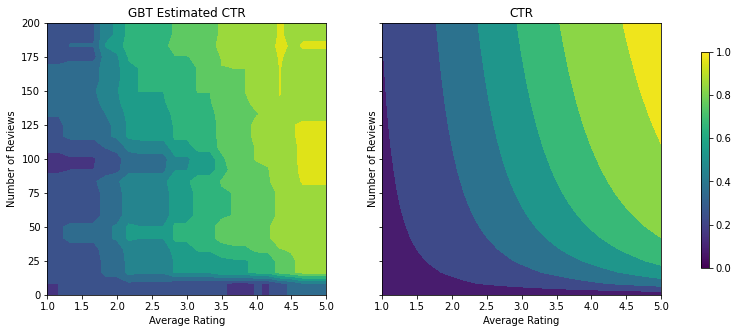

In [11]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
]
gbt_estimator = tf.estimator.BoostedTreesClassifier(
    feature_columns=feature_columns,
    # Hyper-params optimized on validation set.
    n_batches_per_layer=1,
    max_depth=2,
    n_trees=50,
    learning_rate=0.05,
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
gbt_estimator.train(input_fn=train_input_fn)
analyze_two_d_estimator(gbt_estimator, "GBT")

모델이 실제 CTR의 일반적인 형상을 포착하고 적절한 검증 메트릭을 가지고 있지만, 입력 공간의 여러 부분에서 반직관적인 동작을 보입니다. 평균 평점 또는 리뷰 수가 증가하면 예상 CTR이 감소하는데, 이는 훈련 데이터세트에서 잘 다루지 않는 영역에 샘플 포인트가 부족하기 때문입니다. 모델은 데이터에서만 올바른 동작을 추론할 방법이 없습니다.

이 문제를 해결하기 위해 모델이 평균 평점과 리뷰 수에 대해 단조롭게 증가하는 값을 출력해야 한다는 형상 제약 조건을 적용합니다. 나중에 TFL에서 이를 구현하는 방법을 살펴보겠습니다.


## DNN 적합화하기

DNN 분류자로 같은 단계를 반복할 수 있습니다. 여기서 비슷한 패턴이 관찰되는데 리뷰 수가 적은 샘플 포인트가 충분하지 않으면 무의미한 외삽이 발생합니다. 검증 메트릭이 트리 솔루션보다 우수하더라도 테스트 메트릭은 훨씬 나쁘다는 점을 유의하세요.

Validation AUC: 0.6483383178710938


Testing AUC: 0.7496159076690674


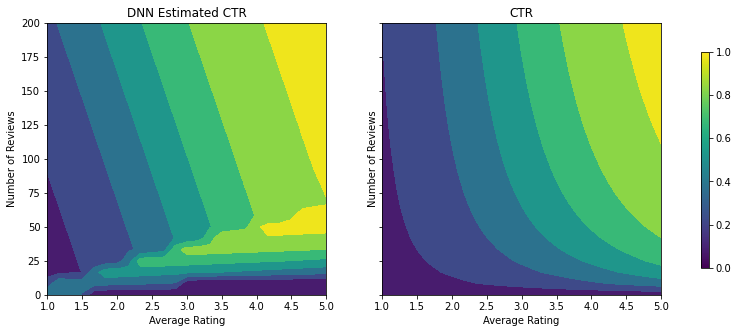

In [12]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
]
dnn_estimator = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    # Hyper-params optimized on validation set.
    hidden_units=[16, 8, 8],
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
dnn_estimator.train(input_fn=train_input_fn)
analyze_two_d_estimator(dnn_estimator, "DNN")

## 형상 제약 조건

TensorFlow Lattice(TFL)는 훈련 데이터 이상의 모델 동작을 보호하기 위해 형상 제약 조건을 적용하는 데 중점을 둡니다. 이러한 형상 제약 조건은 TFL Keras 레이어에 적용됩니다. 자세한 내용은 [JMLR 논문](http://jmlr.org/papers/volume17/15-243/15-243.pdf)에서 찾을 수 있습니다.

이 튜토리얼에서는 다양한 형상 제약을 다루기 위해 준비된 TF estimator를 사용하지만, 해당 모든 단계는 TFL Keras 레이어에서 생성된 모델로 수행할 수 있습니다.

다른 TensorFlow estimator와 마찬가지로 준비된 TFL estimator는 [특성 열](https://www.tensorflow.org/api_docs/python/tf/feature_column)을 사용하여 입력 형식을 정의하고 훈련 input_fn을 사용하여 데이터를 전달합니다. 준비된 TFL estimator을 사용하려면 다음이 필요합니다.

- *모델 구성*: 모델 아키텍처 및 특성별 형상 제약 조건 및 regularizer를 정의합니다.
- *특성 분석 input_fn*: TFL 초기화를 위해 데이터를 전달하는 TF input_fn.

자세한 설명은 준비된 estimator 튜토리얼 또는 API 설명서를 참조하세요.

### 단조

먼저 두 특성에 단조 형상 제약 조건을 추가하여 단조 문제를 해결합니다.

TFL에 형상 제약 조건을 적용하기 위해 *특성 구성*에 제약 조건을 지정합니다. 다음 코드는 `monotonicity="increasing"`을 설정하여 `num_reviews` 및 `avg_rating` 모두에 대해 출력이 단조롭게 증가하도록 요구할 수 있는 방법을 보여줍니다.


Validation AUC: 0.6553398370742798


Testing AUC: 0.7784496545791626


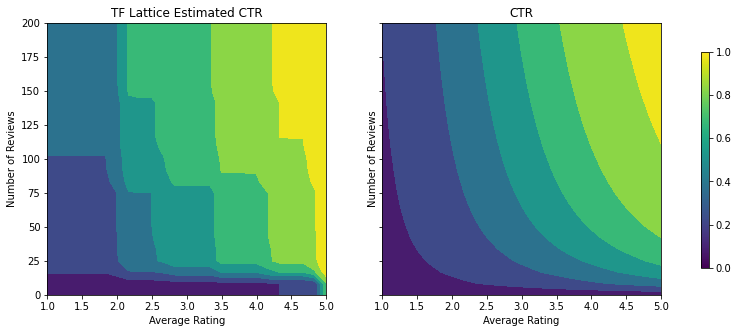

In [13]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=20,
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=20,
        )
    ])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)
analyze_two_d_estimator(tfl_estimator, "TF Lattice")

`CalibratedLatticeConfig`를 사용하면 먼저 *calibrator*를 각 입력(숫자 특성에 대한 부분 선형 함수)에 적용한 다음 *격자* 레이어를 적용하여 보정된 특성을 비선형적으로 융합하는 준비된 분류자를 생성합니다. `tfl.visualization`을 사용하여 모델을 시각화할 수 있습니다. 특히 다음 플롯은 미리 준비된 estimator에 포함된 두 개의 훈련된 calibrator를 보여줍니다.


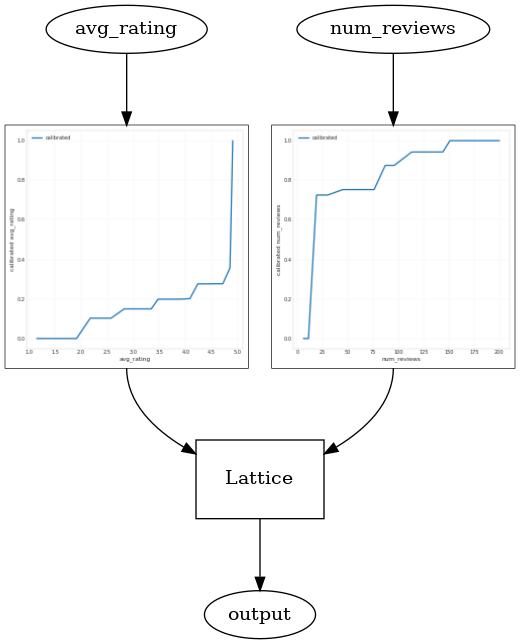

In [14]:
def save_and_visualize_lattice(tfl_estimator):
  saved_model_path = tfl_estimator.export_saved_model(
      "/tmp/TensorFlow_Lattice_101/",
      tf.estimator.export.build_parsing_serving_input_receiver_fn(
          feature_spec=tf.feature_column.make_parse_example_spec(
              feature_columns)))
  model_graph = tfl.estimators.get_model_graph(saved_model_path)
  figsize(8, 8)
  tfl.visualization.draw_model_graph(model_graph)
  return model_graph

_ = save_and_visualize_lattice(tfl_estimator)

제약 조건이 추가되면 평균 평점이 증가하거나 리뷰 수가 증가함에 따라 예상 CTR이 항상 증가합니다. 이것은 calibrator와 격자가 단조로운지 확인하여 수행됩니다.

### 감소 수익

[감소 수익](https://en.wikipedia.org/wiki/Diminishing_returns)은 특정 특성값을 증가시키는 한계 이득이 값이 증가함에 따라 감소한다는 것을 의미합니다. 해당 경우에는 `num_reviews` 특성이 이 패턴을 따를 것으로 예상하므로 그에 따라 calibrator를 구성할 수 있습니다. 감소하는 수익률은 두 가지 충분한 조건으로 분해할 수 있습니다.

- calibrator가 단조롭게 증가하고 있으며
- calibrator는 오목합니다.


Validation AUC: 0.6403099298477173


Testing AUC: 0.7891009449958801


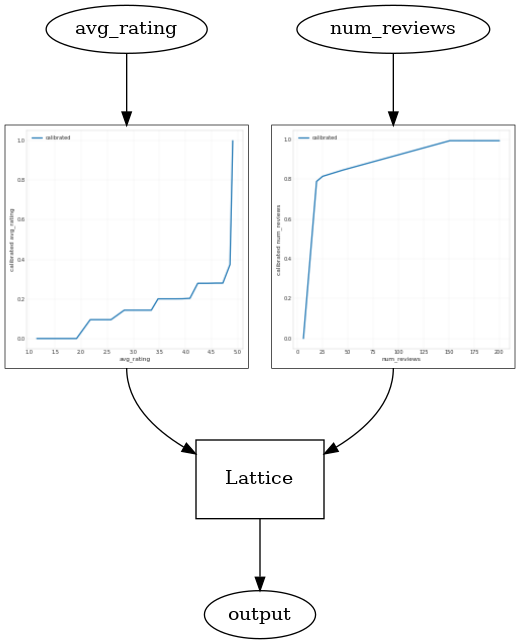

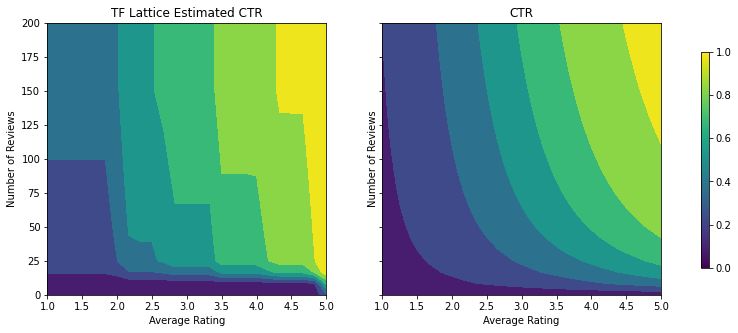

In [15]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_convexity="concave",
            pwl_calibration_num_keypoints=20,
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=20,
        )
    ])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)
analyze_two_d_estimator(tfl_estimator, "TF Lattice")
_ = save_and_visualize_lattice(tfl_estimator)

오목 제약 조건을 추가하여 테스트 메트릭이 어떻게 향상되는지 확인하세요. 예측 플롯은 또한 지상 진실과 더 유사합니다.

### 2D 형상 제약 조건: 신뢰

리뷰가 한두 개밖에 없는 레스토랑의 별 5개는 신뢰할 수 없는 평가일 가능성이 높지만(실제 레스토랑 경험은 나쁠 수 있습니다), 수백 개의 리뷰가 있는 레스토랑에 대한 4성급은 훨씬 더 신뢰할 수 있습니다(이 경우에 레스토랑 경험은 좋을 것입니다). 레스토랑 리뷰 수는 평균 평점에 대한 신뢰도에 영향을 미친다는 것을 알 수 있습니다.

TFL 신뢰 제약 조건을 실행하여 한 특성의 더 큰(또는 더 작은) 값이 다른 특성에 대한 더 많은 신뢰 또는 신뢰를 나타냄을 모델에 알릴 수 있습니다. 이는 특성 구성에서 `reflects_trust_in` 구성을 설정하여 수행됩니다.

Validation AUC: 0.6407766938209534


Testing AUC: 0.7891259789466858


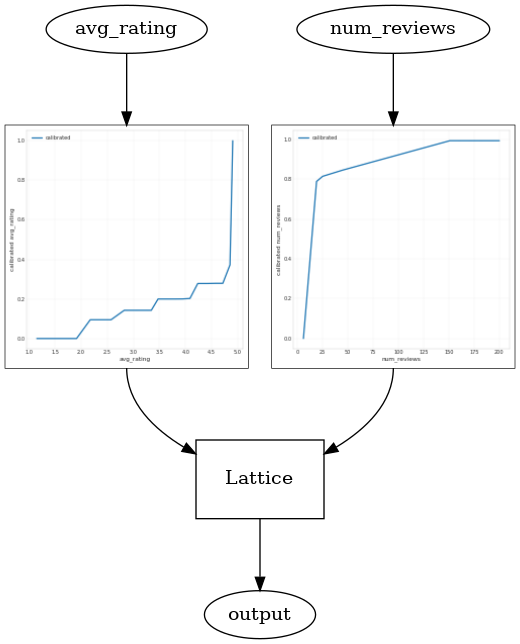

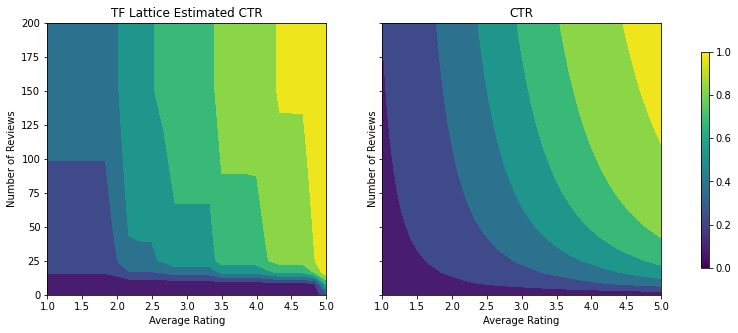

In [16]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_convexity="concave",
            pwl_calibration_num_keypoints=20,
            # Larger num_reviews indicating more trust in avg_rating.
            reflects_trust_in=[
                tfl.configs.TrustConfig(
                    feature_name="avg_rating", trust_type="edgeworth"),
            ],
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=20,
        )
    ])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)
analyze_two_d_estimator(tfl_estimator, "TF Lattice")
model_graph = save_and_visualize_lattice(tfl_estimator)

다음 플롯은 훈련된 격자 함수를 나타냅니다. 신뢰 제약 조건으로 인해, 보정된 `num_reviews`의 큰 값이 보정된 `avg_rating`에 대한 경사를 더 높여서 격자 출력에서 더 중요한 이동이 있을 것을 예상합니다.

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/tensorflow_lattice/python/visualization.py:575: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes = figure.gca(projection='3d')


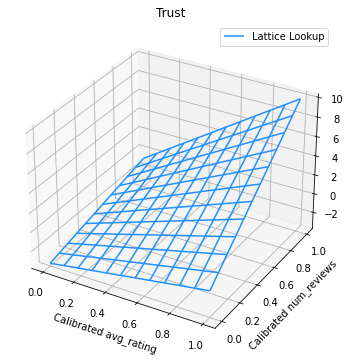

In [17]:
lat_mesh_n = 12
lat_mesh_x, lat_mesh_y = tfl.test_utils.two_dim_mesh_grid(
    lat_mesh_n**2, 0, 0, 1, 1)
lat_mesh_fn = tfl.test_utils.get_hypercube_interpolation_fn(
    model_graph.output_node.weights.flatten())
lat_mesh_z = [
    lat_mesh_fn([lat_mesh_x.flatten()[i],
                 lat_mesh_y.flatten()[i]]) for i in range(lat_mesh_n**2)
]
trust_plt = tfl.visualization.plot_outputs(
    (lat_mesh_x, lat_mesh_y),
    {"Lattice Lookup": lat_mesh_z},
    figsize=(6, 6),
)
trust_plt.title("Trust")
trust_plt.xlabel("Calibrated avg_rating")
trust_plt.ylabel("Calibrated num_reviews")
trust_plt.show()

### Smoothing Calibrator

이제 `avg_rating`의 calibrator를 살펴보겠습니다. 단조롭게 증가하지만 기울기의 변화는 갑작스럽고 해석하기 어렵습니다. 이는 `regularizer_configs`의 regularizer 설정으로 이 calibrator를 스무딩하는 것을 고려해볼 수 있음을 의미합니다.

여기에서는 곡률의 변화를 줄이기 위해 `wrinkle` regularizer를 적용합니다. 또한 `laplacian` regularizer를 사용하여 calibrator를 평면화하고 `hessian` regularizer를 사용하여 보다 선형적으로 만들 수 있습니다.


Validation AUC: 0.6465646028518677


Testing AUC: 0.7948338389396667


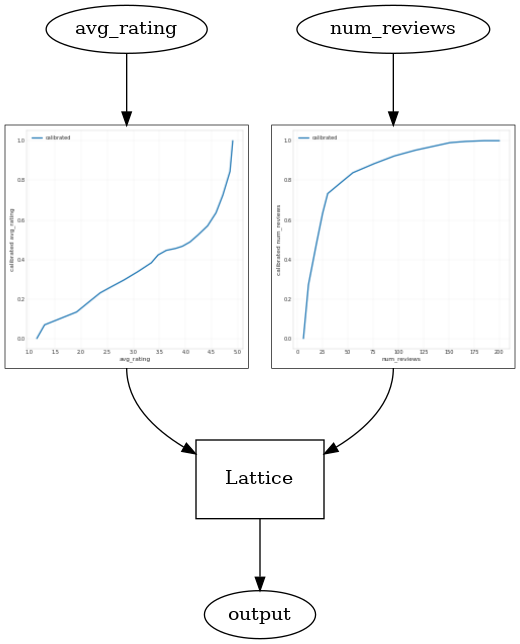

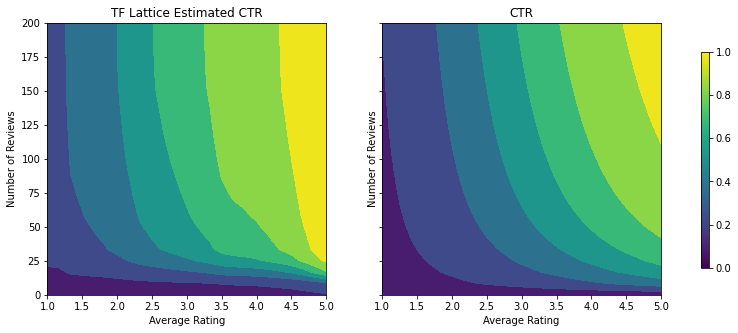

In [18]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_convexity="concave",
            pwl_calibration_num_keypoints=20,
            regularizer_configs=[
                tfl.configs.RegularizerConfig(name="calib_wrinkle", l2=1.0),
            ],
            reflects_trust_in=[
                tfl.configs.TrustConfig(
                    feature_name="avg_rating", trust_type="edgeworth"),
            ],
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=20,
            regularizer_configs=[
                tfl.configs.RegularizerConfig(name="calib_wrinkle", l2=1.0),
            ],
        )
    ])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)
analyze_two_d_estimator(tfl_estimator, "TF Lattice")
_ = save_and_visualize_lattice(tfl_estimator)

이제 calibrator가 매끄럽고 전체 예상 CTR이 실제와 더 잘 일치합니다. 해당 적용은 테스트 메트릭과 등고선 플롯 모두에 반영됩니다.

### 범주형 보정을 위한 부분 단조

지금까지 모델에서 숫자 특성 중 두 가지만 사용했습니다. 여기에서는 범주형 보정 레이어를 사용하여 세 번째 특성을 추가합니다. 다시 플롯 및 메트릭 계산을 위한 도우미 함수를 설정하는 것으로 시작합니다.

In [19]:
def analyze_three_d_estimator(estimator, name):
  # Extract validation metrics.
  metric = estimator.evaluate(input_fn=val_input_fn)
  print("Validation AUC: {}".format(metric["auc"]))
  metric = estimator.evaluate(input_fn=test_input_fn)
  print("Testing AUC: {}".format(metric["auc"]))

  def three_d_pred(avg_ratings, num_reviews, dollar_rating):
    results = estimator.predict(
        tf.compat.v1.estimator.inputs.pandas_input_fn(
            x=pd.DataFrame({
                "avg_rating": avg_ratings,
                "num_reviews": num_reviews,
                "dollar_rating": dollar_rating,
            }),
            shuffle=False,
        ))
    return [x["logistic"][0] for x in results]

  figsize(11, 22)
  plot_fns([("{} Estimated CTR".format(name), three_d_pred),
            ("CTR", click_through_rate)],
           split_by_dollar=True)
  

세 번째 특성인 `dollar_rating`을 포함하려면 범주형 특성이 특성 열과 특성 구성 모두에서 TFL 내에서 약간 다른 처리가 필요하다는 점을 기억해야 합니다. 여기서 다른 모든 입력이 고정될 때 'DD' 레스토랑의 출력이 'D' 레스토랑보다 커야 한다는 부분 단조 제약 조건을 적용합니다. 해당 적용은 특성 구성에서 `monotonicity` 설정을 사용하여 수행됩니다.

Validation AUC: 0.7714711427688599


Testing AUC: 0.8594028949737549


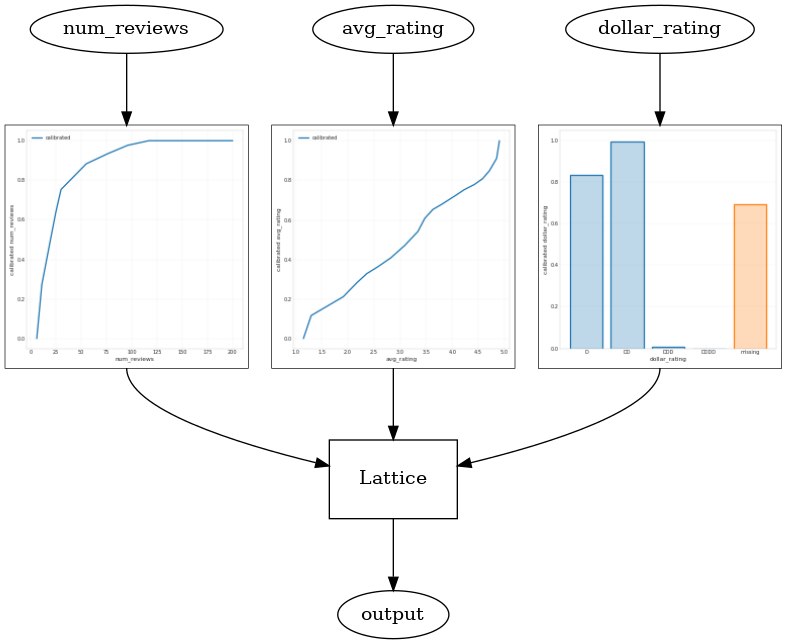

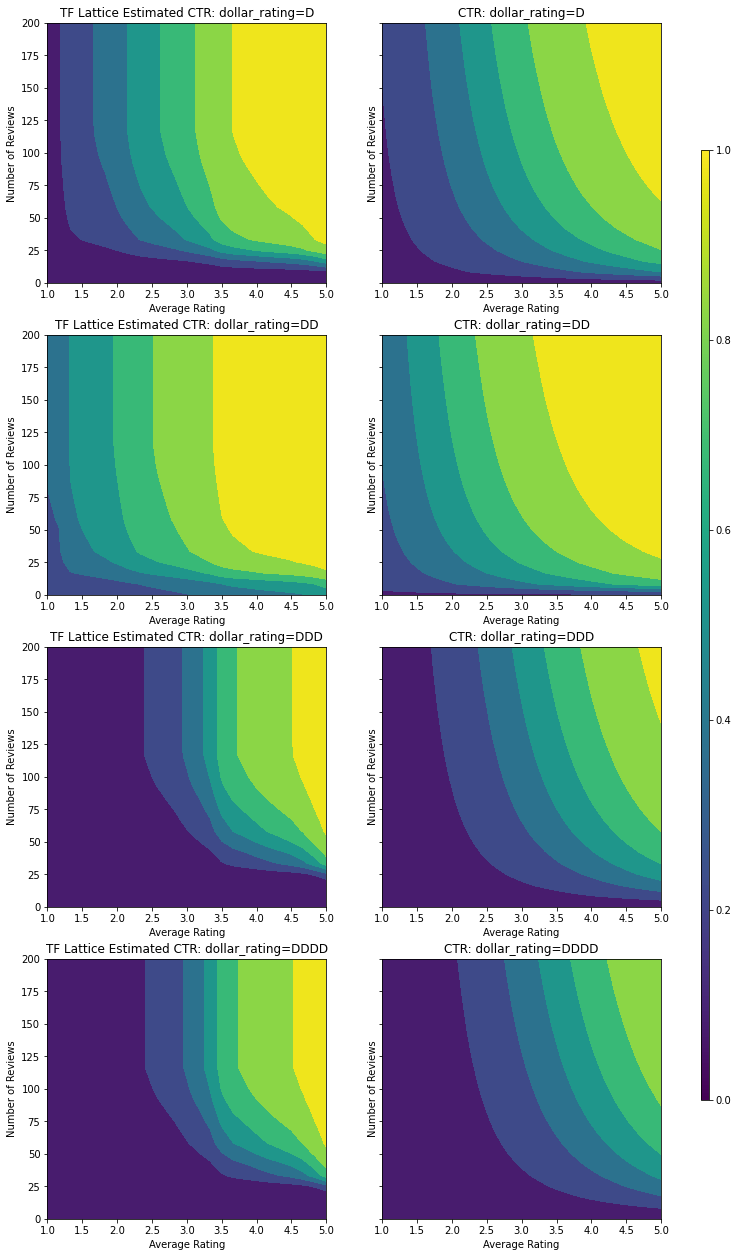

In [20]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
    tf.feature_column.categorical_column_with_vocabulary_list(
        "dollar_rating",
        vocabulary_list=["D", "DD", "DDD", "DDDD"],
        dtype=tf.string,
        default_value=0),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_convexity="concave",
            pwl_calibration_num_keypoints=20,
            regularizer_configs=[
                tfl.configs.RegularizerConfig(name="calib_wrinkle", l2=1.0),
            ],
            reflects_trust_in=[
                tfl.configs.TrustConfig(
                    feature_name="avg_rating", trust_type="edgeworth"),
            ],
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=20,
            regularizer_configs=[
                tfl.configs.RegularizerConfig(name="calib_wrinkle", l2=1.0),
            ],
        ),
        tfl.configs.FeatureConfig(
            name="dollar_rating",
            lattice_size=2,
            pwl_calibration_num_keypoints=4,
            # Here we only specify one monotonicity:
            # `D` resturants has smaller value than `DD` restaurants
            monotonicity=[("D", "DD")],
        ),
    ])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)
analyze_three_d_estimator(tfl_estimator, "TF Lattice")
_ = save_and_visualize_lattice(tfl_estimator)

범주형 calibrator는 모델 출력의 선호도를 보여줍니다. DD &gt; D &gt; DDD &gt; DDDD는 설정과 일치합니다. 결측값에 대한 열도 있습니다. 훈련 및 테스트 데이터에는 누락된 특성이 없지만, 모델은 다운스트림 모델 제공 중에 발생하는 누락된 값에 대한 대체 값을 제공합니다.

`dollar_rating`을 조건으로 이 모델의 예상 CTR도 플롯합니다. 필요한 모든 제약 조건이 각 슬라이스에서 충족됩니다.

### 출력 보정

지금까지 훈련한 모든 TFL 모델의 경우 격자 레이어(모델 그래프에서 'Lattice'로 표시됨)가 모델 예측을 직접 출력합니다. 때때로 격자 출력이 모델 출력을 내도록 재조정되어야 하는지는 확실하지 않습니다.

- 특성은 $log$ 카운트이고 레이블은 카운트입니다.
- 격자는 매우 적은 수의 꼭짓점을 갖도록 구성되지만 레이블 분포는 비교적 복잡합니다.

이러한 경우 격자 출력과 모델 출력 사이에 또 다른 calibrator를 추가하여 모델 유연성을 높일 수 있습니다. 방금 구축한 모델에 5개의 키포인트가 있는 보정 레이어를 추가하겠습니다. 또한 함수를 원활하게 유지하기 위해 출력 calibrator용 regularizer를 추가합니다.


Validation AUC: 0.769044041633606


Testing AUC: 0.861021876335144


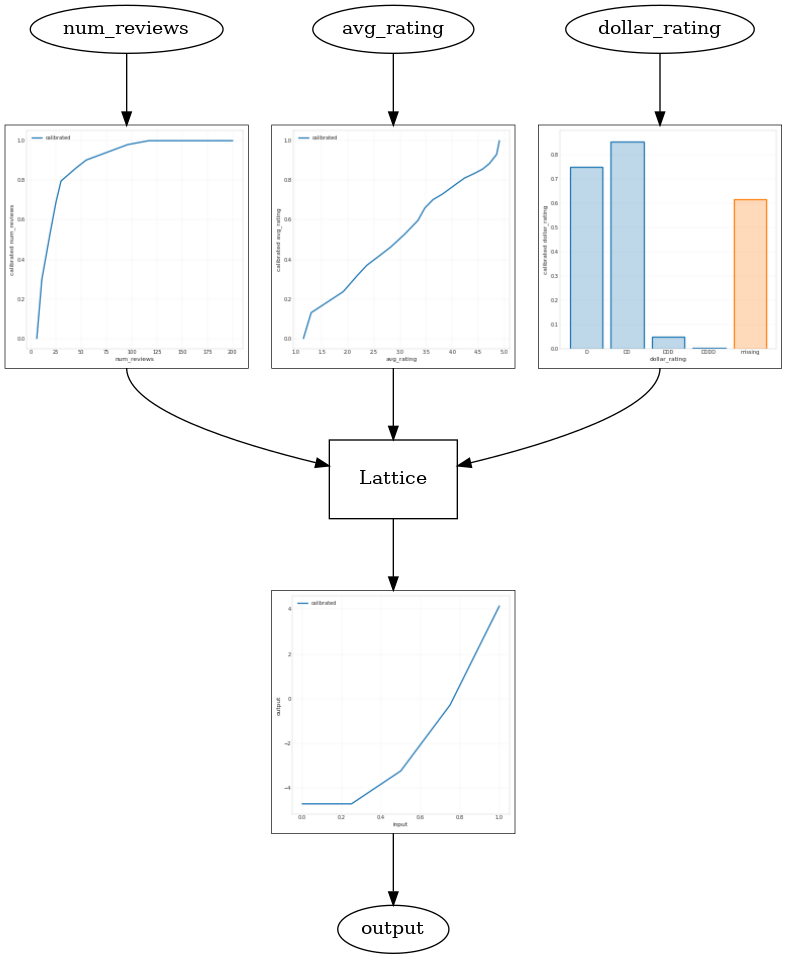

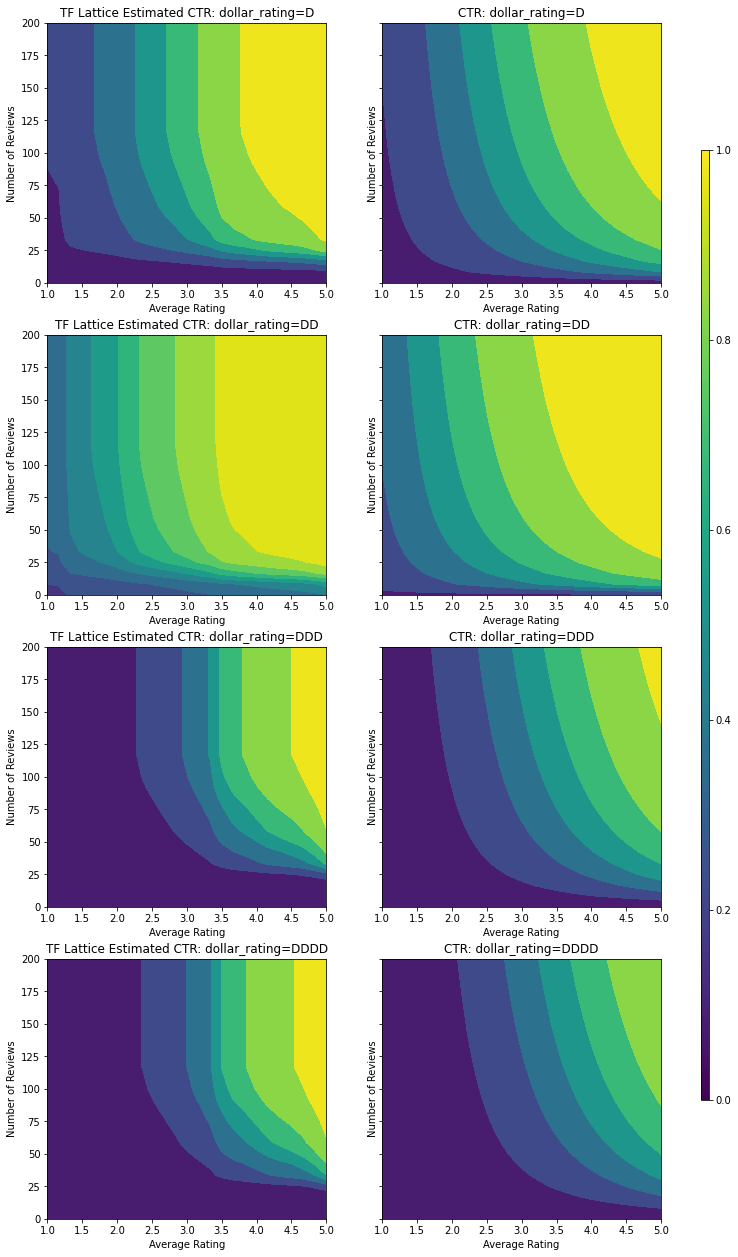

In [21]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
    tf.feature_column.categorical_column_with_vocabulary_list(
        "dollar_rating",
        vocabulary_list=["D", "DD", "DDD", "DDDD"],
        dtype=tf.string,
        default_value=0),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    output_calibration=True,
    output_calibration_num_keypoints=5,
    regularizer_configs=[
        tfl.configs.RegularizerConfig(name="output_calib_wrinkle", l2=0.1),
    ],
    feature_configs=[
    tfl.configs.FeatureConfig(
        name="num_reviews",
        lattice_size=2,
        monotonicity="increasing",
        pwl_calibration_convexity="concave",
        pwl_calibration_num_keypoints=20,
        regularizer_configs=[
            tfl.configs.RegularizerConfig(name="calib_wrinkle", l2=1.0),
        ],
        reflects_trust_in=[
            tfl.configs.TrustConfig(
                feature_name="avg_rating", trust_type="edgeworth"),
        ],
    ),
    tfl.configs.FeatureConfig(
        name="avg_rating",
        lattice_size=2,
        monotonicity="increasing",
        pwl_calibration_num_keypoints=20,
        regularizer_configs=[
            tfl.configs.RegularizerConfig(name="calib_wrinkle", l2=1.0),
        ],
    ),
    tfl.configs.FeatureConfig(
        name="dollar_rating",
        lattice_size=2,
        pwl_calibration_num_keypoints=4,
        # Here we only specify one monotonicity:
        # `D` resturants has smaller value than `DD` restaurants
        monotonicity=[("D", "DD")],
    ),
])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)
analyze_three_d_estimator(tfl_estimator, "TF Lattice")
_ = save_and_visualize_lattice(tfl_estimator)

최종 테스트 메트릭과 플롯은 상식적인 제약 조건을 사용하는 것이 모델이 예기치 않은 동작을 방지하고 전체 입력 공간으로 더 잘 외삽하는 데 어떻게 도움이 되는지 보여줍니다.